In [1]:
!pip install torch torchvision -q

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

import torch
from torch import nn

##### Lambda Transformations
Lambda transforms apply any user-defined lambda function. Here, we define a function to turn the
integer into a one-hot encoded tensor.

It first creates a zero tensor of size 10 (the number of labels in our dataset)
and calls scatter_ which assigns a value=1 on the index as given by the label y.

In [6]:
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda

training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform = Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(dim=0, index=torch.tensor(y), value=1))
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
    target_transform = Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(dim=0, index=torch.tensor(y), value=1))
)

### Iterating and Visualizing the Dataset

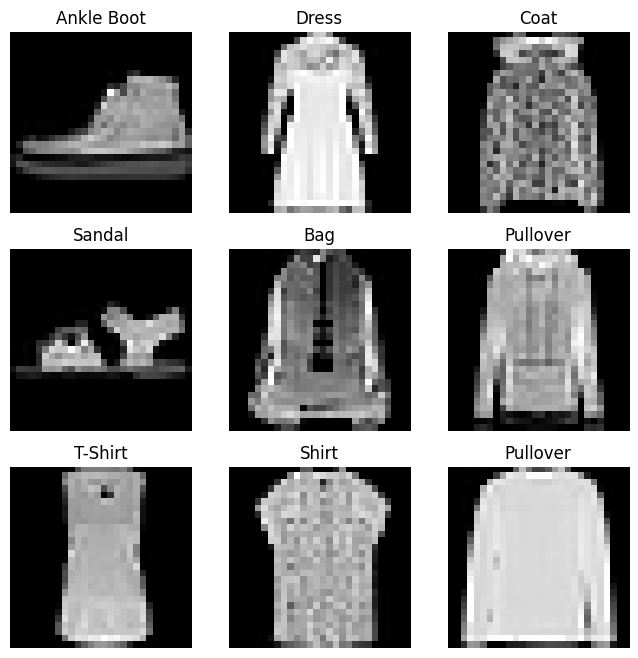

In [26]:
labels_map = {
  0: "T-Shirt",
  1: "Trouser",
  2: "Pullover",
  3: "Dress",
  4: "Coat",
  5: "Sandal",
  6: "Shirt",
  7: "Sneaker",
  8: "Bag",
  9: "Ankle Boot"
}

figure = plt.figure(figsize=(8,8))
rows, cols = 3, 3
for i in range(1, rows*cols + 1):
  sample_idx = torch.randint(len(training_data), size=(1,)).item()
  img, label = training_data[sample_idx]
  figure.add_subplot(rows, cols, i)
  plt.title(labels_map[(label == 1).nonzero(as_tuple=False)[0].item()])
  plt.axis("off")
  plt.imshow(img.squeeze(0), cmap="gray")

plt.show()

In [27]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

#### Iterate through the DataLoader

Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64, 10])


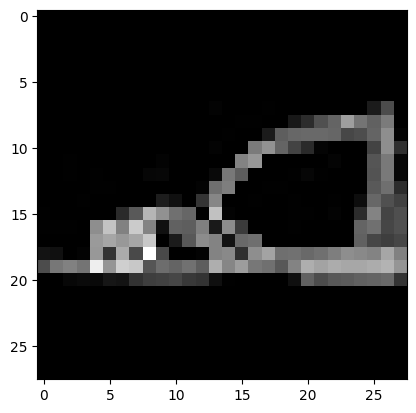

Label: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.])


In [28]:
# Display image and label
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

##### Get Device for Training
Let's check to see if ```torch.cuda``` or ```torch.backends.mps``` are available, otherwise use CPU.

In [29]:
device = (
    "cuda" if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device.")

Using cpu device.


In [32]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
            nn.ReLU()
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(f"Model structure: {model} \n\n")
for name, param in model.named_parameters():
  print(f"Layer: {name} | Size: {param.size()} | Values: {param[:2]}\n")

Model structure: NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
    (5): ReLU()
  )
) 


Layer: linear_relu_stack.0.weight | Size: torch.Size([512, 784]) | Values: tensor([[ 0.0254, -0.0130,  0.0111,  ...,  0.0180, -0.0220,  0.0134],
        [ 0.0333,  0.0353,  0.0198,  ..., -0.0235, -0.0135, -0.0194]],
       grad_fn=<SliceBackward0>)

Layer: linear_relu_stack.0.bias | Size: torch.Size([512]) | Values: tensor([-0.0065, -0.0048], grad_fn=<SliceBackward0>)

Layer: linear_relu_stack.2.weight | Size: torch.Size([512, 512]) | Values: tensor([[ 0.0223, -0.0207, -0.0113,  ..., -0.0232,  0.0021, -0.0121],
        [-0.0305,  0.0285, -0.0375,  ...,  0.0334,  0.0218,  0.0403]],
       grad_fn=<SliceBackward0>)

Layer: linear_relu_stac

```nn.Flatten```
the nn.Flatten layer convert each 2D 28x28 image into a contiguous array of 784 pixel values (the minibatch dimension is maintained.

```nn.Sequential```
nn.Sequential is an ordered container of modules. The data is passed thorugh all the modules in the same order as defined.

In [33]:
learning_rate = 1e-3
batch_size = 64

#### Loss Function
Common loss functions include,
```nn.MSELoss``` Mean Square Error for regression tasks
```nn.NLLLoss``` Negative Log Likelyhood for classification.
```nn.CrossEntropyLoss``` combines nn.LogSoftmax and nn.NLLLoss - which normalize the logits and compute the prediction error.

In [34]:
loss_fn = nn.CrossEntropyLoss()

#### Optimizer
Optimization is the process of adjusting model parameters to reduce model error in each training step.
All optiimization logic is encapsulated in the optimizer object.
Here Stochastic Gradient Descent is used.

In [35]:
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [59]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        pred = model(X)
        loss = loss_fn(pred, y)

        # optimizer.zero_grad() to reset the gradients of model parameters. Gradients by default add up; to prevent double
        # counting, we explicitly zero them at each iteration.
        # loss.backward() backpropagates prediction loss. PyTorch deposits gradients of the loss w.r.t. each parameter.
        # optimizer.step() to adjust the parameters by the gradients collected in the backward pass.
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f} [{current:>5d}/{size:>5d}]")

def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            #print(pred.argmax(1), (y == 1).nonzero(as_tuple=True)[1])
            correct += (pred.argmax(1) ==(y == 1).nonzero(as_tuple=True)[1]).type(torch.float).sum().item()

    test_loss /= size
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss:{test_loss:>8f} \n")

Each epoch consists of two main parts:
- The Treain loop - iterate over the training dataset and try to converge to optimal parameters.
- The Validation/Test loop - iterate over the test dataset to check if model performance is improving.

In [60]:
epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-----------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)

print("Done!")

Epoch 1
-----------------------------
loss: 2.201983 [    0/60000]
loss: 2.216325 [ 6400/60000]
loss: 2.208952 [12800/60000]
loss: 2.184308 [19200/60000]
loss: 2.189353 [25600/60000]
loss: 2.163290 [32000/60000]
loss: 2.133129 [38400/60000]
loss: 2.100174 [44800/60000]
loss: 2.159330 [51200/60000]
loss: 2.120269 [57600/60000]
Test Error: 
 Accuracy: 50.5%, Avg loss:0.032946 

Epoch 2
-----------------------------
loss: 2.103625 [    0/60000]
loss: 2.076454 [ 6400/60000]
loss: 2.079592 [12800/60000]
loss: 2.123228 [19200/60000]
loss: 2.081446 [25600/60000]
loss: 1.957071 [32000/60000]
loss: 1.960337 [38400/60000]
loss: 1.982034 [44800/60000]
loss: 1.912419 [51200/60000]
loss: 1.980467 [57600/60000]
Test Error: 
 Accuracy: 49.4%, Avg loss:0.030221 

Epoch 3
-----------------------------
loss: 1.916312 [    0/60000]
loss: 1.929315 [ 6400/60000]
loss: 1.881819 [12800/60000]
loss: 1.922919 [19200/60000]
loss: 1.796440 [25600/60000]
loss: 1.787337 [32000/60000]
loss: 1.574667 [38400/60000]
l

The last linear layer of the neural network returns logits - raw values in [-infinity, infinity] - which are
passed to the nn.Softmax module. the logits are scaled to values [0, 1] representing the model's predicted probabiliteis for eache class.

In [61]:
torch.save(model.state_dict(), "data/model.pth")

print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth
